# New Section

In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
#from keras.models import attention
#from keras.layers.Attention import attention 
#from attention import attention_3d_block
#from tensorflow.keras.models import Model
#from tensorflow.keras.models import Model
#from tensorflow.keras.models import Model
#from tensorflow.python.keras.layers import Input
from keras.layers import Input
#from tensorflow.python.keras.layers import Input

In [ ]:
#from Model.attention_module import se_block, cbam_block

In [ ]:
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K
from keras.activations import sigmoid

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [ ]:
train_path = '/content/drive/My Drive/Colab Notebooks/dataset1/dataset1/train'
valid_path = '/content/drive/My Drive/Colab Notebooks/dataset1/dataset1/test'

In [ ]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	#channel =  input_feature._keras_shape
	channel =  input_feature.shape[channel_axis]

	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal', 
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	#assert avg_pool._keras_shape[1:] == (1,1,channel)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	#assert avg_pool._keras_shape[1:] == (1,1,channel//ratio)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	#assert avg_pool._keras_shape[1:] == (1,1,channel)
	assert avg_pool.shape[1:] == (1,1,channel)
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	#assert max_pool._keras_shape[1:] == (1,1,channel)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
  #assert max_pool._keras_shape[1:] == (1,1,channel//ratio)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
  #assert max_pool._keras_shape[1:] == (1,1,channel)
	assert max_pool.shape[1:] == (1,1,channel)
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

In [ ]:
def spatial_attention(input_feature):
	kernel_size = 7
	
	if K.image_data_format() == "channels_first":
		channel = input_feature._keras_shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])

In [ ]:
def cbam_block(cbam_feature, ratio=8):

	
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

In [ ]:
c=cbam_block(vgg.output)
print(c)

KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 512), dtype=tf.float32, name=None), name='multiply_1/mul:0', description="created by layer 'multiply_1'")


In [ ]:

x = Flatten()(c)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(2, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy]
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])

In [ ]:

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/My Drive/Colab Notebooks/dataset1/dataset1/train',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 )

test_set = test_datagen.flow_from_directory('/content/drive/My Drive/Colab Notebooks/dataset1/dataset1/test',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            )

Found 1600 images belonging to 2 classes.
Found 340 images belonging to 2 classes.


In [ ]:
print(len(training_set))

100


In [ ]:
r = model.fit_generator(
  training_set,
   validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set))


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
100/100 [==============================] - 652s 6s/step - loss: 0.4552 - accuracy: 0.7734 - val_loss: 0.2453 - val_accuracy: 0.9000
Epoch 2/5
100/100 [==============================] - 9s 89ms/step - loss: 0.0843 - accuracy: 0.9655 - val_loss: 0.1989 - val_accuracy: 0.9324
Epoch 3/5
100/100 [==============================] - 9s 89ms/step - loss: 0.0383 - accuracy: 0.9906 - val_loss: 0.1973 - val_accuracy: 0.9206
Epoch 4/5
100/100 [==============================] - 9s 90ms/step - loss: 0.0234 - accuracy: 0.9956 - val_loss: 0.2263 - val_accuracy: 0.9088
Epoch 5/5
100/100 [==============================] - 9s 91ms/step - loss: 0.0139 - accuracy: 0.9992 - val_loss: 0.2117 - val_accuracy: 0.9176


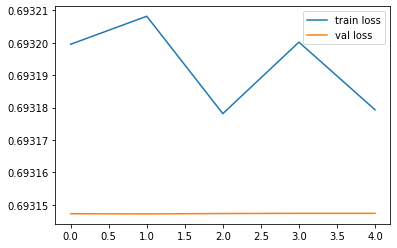

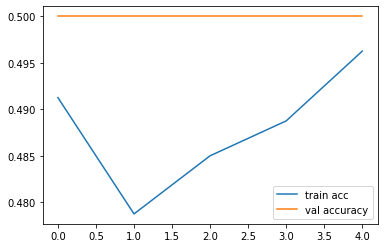

<Figure size 432x288 with 0 Axes>

In [ ]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_accuracy')